In [ ]:
import numpy
import math
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
## Neural network class
class PINN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, num_layers):
    super(PINN, self).__init__()
    activation = nn.Tanh
    self.input_layer = nn.Linear(input_size, hidden_size)
    self.hidden_layers = nn.ModuleList([nn.Sequential(nn.Linear(hidden_size, hidden_size),activation()) for _ in range(num_layers)])
    self.output_layer = nn.Linear(hidden_size, output_size)

  def forward(self, x, y):
    input_data = torch.cat((x, y), -1)
    output = torch.tanh(self.input_layer(input_data))
    for layer in self.hidden_layers:
      output = layer(output)
    output = self.output_layer(output)
    return output

In [ ]:
## Defining the Steady state heat PDE
def heat_equation(T, x, y):
    T_x = torch.autograd.grad(T, x, torch.ones_like(T), create_graph=True)[0]
    T_xx = torch.autograd.grad(T_x, x, torch.ones_like(T), create_graph=True)[0]
    T_y = torch.autograd.grad(T, y, torch.ones_like(T), create_graph=True)[0]
    T_yy = torch.autograd.grad(T_y, y, torch.ones_like(T), create_graph=True)[0]
    return T_xx + T_yy

In [ ]:
## PDE training data
x1 = torch.linspace(0, 1, 20).view(-1, 1)
y1 = torch.linspace(0, 1, 20).view(-1, 1)
x1 = x1.view(-1)
y1 = y1.view(-1)
x_train1, y_train1 = torch.meshgrid(x1, y1)
x_train1 = x_train1.reshape(400, 1).requires_grad_(True)
y_train1 = y_train1.reshape(400, 1).requires_grad_(True)

In [ ]:
## y = 0 Boundary condition training data
x2 = torch.linspace(0, 1, 20).view(-1, 1)
y2 = torch.tensor(0.)
x2 = x2.view(-1)
y2 = y2.view(-1)
x_train2, y_train2 = torch.meshgrid(x2, y2)
x_train_y0 = x_train2.reshape(20, 1).requires_grad_(True)
y_train_y0 = y_train2.reshape(20, 1).requires_grad_(True)
T_train_y0 = torch.ones_like(x_train_y0)*0

In [ ]:
## y = 1 Boundary condition training data
x3 = torch.linspace(0, 1, 20).view(-1, 1)
y3 = torch.tensor(1.)
x3 = x3.view(-1)
y3 = y3.view(-1)
x_train3, y_train3 = torch.meshgrid(x3, y3)
x_train_y1 = x_train3.reshape(20, 1).requires_grad_(True)
y_train_y1 = y_train3.reshape(20, 1).requires_grad_(True)
T_train_y1 = torch.ones_like(x_train_y1)*10

In [ ]:
## x = 0 Boundary condition training data
y4 = torch.linspace(0, 1, 20).view(-1, 1)
x4 = torch.tensor(0.)
x4 = x4.view(-1)
y4 = y4.view(-1)
x_train4, y_train4 = torch.meshgrid(x4, y4)
x_train_x0 = x_train4.reshape(20, 1).requires_grad_(True)
y_train_x0 = y_train4.reshape(20, 1).requires_grad_(True)
T_train_x0 = 10*y_train_x0
T_train_x0

tensor([[ 0.0000],
        [ 0.5263],
        [ 1.0526],
        [ 1.5789],
        [ 2.1053],
        [ 2.6316],
        [ 3.1579],
        [ 3.6842],
        [ 4.2105],
        [ 4.7368],
        [ 5.2632],
        [ 5.7895],
        [ 6.3158],
        [ 6.8421],
        [ 7.3684],
        [ 7.8947],
        [ 8.4211],
        [ 8.9474],
        [ 9.4737],
        [10.0000]], grad_fn=<MulBackward0>)

In [ ]:
## x = 1 Boundary condition training data
y5 = torch.linspace(0, 1, 20).view(-1, 1)
x5 = torch.tensor(1.)
x5 = x5.view(-1)
y5 = y5.view(-1)
x_train5, y_train5 = torch.meshgrid(x5, y5)
x_train_x1 = x_train5.reshape(20, 1).requires_grad_(True)
y_train_x1 = y_train5.reshape(20, 1).requires_grad_(True)
T_train_x1 = torch.ones_like(x_train_x1)*10*torch.sin(math.pi*y_train_x1*0.5)
T_train_x1

tensor([[ 0.0000],
        [ 0.8258],
        [ 1.6459],
        [ 2.4549],
        [ 3.2470],
        [ 4.0170],
        [ 4.7595],
        [ 5.4695],
        [ 6.1421],
        [ 6.7728],
        [ 7.3572],
        [ 7.8914],
        [ 8.3717],
        [ 8.7947],
        [ 9.1577],
        [ 9.4582],
        [ 9.6940],
        [ 9.8636],
        [ 9.9658],
        [10.0000]], grad_fn=<MulBackward0>)

In [ ]:
## Initialization of PINN
torch.manual_seed(69)
pinn = PINN(2,40,1,10)
optimizer = torch.optim.Adam(pinn.parameters(), lr=0.0001)

In [ ]:
## Training Loop
epochs = 100000
loss_history = []
for epoch in range(epochs):

  optimizer.zero_grad()

  T_pred = pinn(x_train1, y_train1)
  pde_loss = heat_equation(T_pred, x_train1, y_train1).pow(2).mean()

  T_pred_y0 = pinn(x_train_y0, y_train_y0)
  boundary_condition_loss_y0 = (T_pred_y0 - T_train_y0).pow(2).mean()

  T_pred_y1 = pinn(x_train_y1, y_train_y1)
  boundary_condition_loss_y1 = (T_pred_y1 - T_train_y1).pow(2).mean()

  T_pred_x0 = pinn(x_train_x0, y_train_x0)
  boundary_condition_loss_x0 = (T_pred_x0 - T_train_x0).pow(2).mean()

  T_pred_x1 = pinn(x_train_x1, y_train_x1)
  boundary_condition_loss_x1 = (T_pred_x1 - T_train_x1).pow(2).mean()

  p1 = 1
  boundary_condition_loss = boundary_condition_loss_y0 + boundary_condition_loss_y1 + boundary_condition_loss_x0 + boundary_condition_loss_x1
  total_loss = pde_loss + p1*boundary_condition_loss

  total_loss.backward(retain_graph=True)
  optimizer.step()
  loss_history.append(total_loss.item())
  if epoch % 10000 == 0:
      print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item()}, pde Loss: {pde_loss.item()}, Boundary Loss: {boundary_condition_loss.item()}")

Epoch 0/100000, Total Loss: 187.97213745117188, pde Loss: 1.919148218121336e-07, Boundary Loss: 187.97213745117188
Epoch 10000/100000, Total Loss: 0.13651449978351593, pde Loss: 0.03207124397158623, Boundary Loss: 0.1044432520866394
Epoch 20000/100000, Total Loss: 0.06290184706449509, pde Loss: 0.0067202067002654076, Boundary Loss: 0.056181639432907104
Epoch 30000/100000, Total Loss: 0.04498809948563576, pde Loss: 0.007428809534758329, Boundary Loss: 0.03755928948521614
Epoch 40000/100000, Total Loss: 0.029327232390642166, pde Loss: 0.004826228599995375, Boundary Loss: 0.024501003324985504
Epoch 50000/100000, Total Loss: 0.022034816443920135, pde Loss: 0.003605038160458207, Boundary Loss: 0.018429778516292572
Epoch 60000/100000, Total Loss: 0.017050055786967278, pde Loss: 0.0025455602444708347, Boundary Loss: 0.01450449600815773
Epoch 70000/100000, Total Loss: 0.013613605871796608, pde Loss: 0.002255253028124571, Boundary Loss: 0.01135835237801075
Epoch 80000/100000, Total Loss: 0.0465

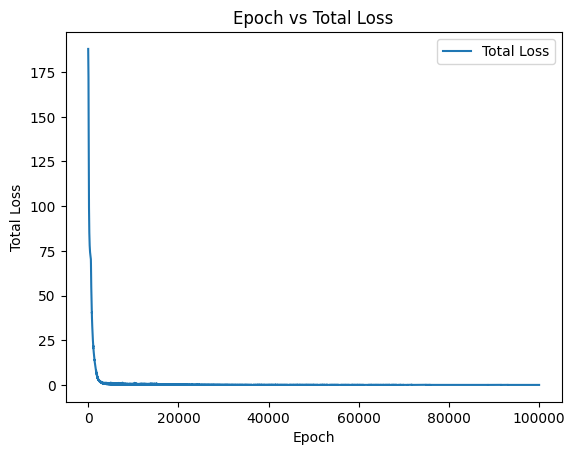

In [ ]:
## Plot for Epoch vs Total Loss
plt.plot(range(epochs), loss_history, label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.title('Epoch vs Total Loss')
plt.legend()
plt.show()

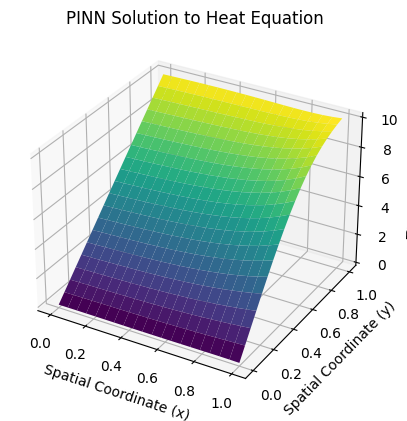

In [ ]:
with torch.no_grad():
    x_plot = torch.linspace(0, 1, 20)
    y_plot = torch.linspace(0, 1, 20)
    X, Y = torch.meshgrid(x_plot, y_plot)
    xy_combined = torch.cat([X.reshape(-1, 1), Y.reshape(-1, 1)], dim=1)
    T_pred_plot = pinn(xy_combined[:, 0].unsqueeze(1), xy_combined[:, 1].unsqueeze(1)).detach().numpy().reshape(X.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X.numpy(), Y.numpy(), T_pred_plot, cmap='viridis')
ax.set_xlabel('Spatial Coordinate (x)')
ax.set_ylabel('Spatial Coordinate (y)')
ax.set_zlabel('Temperature (T)')
ax.set_title('PINN Solution to Heat Equation')
plt.show()

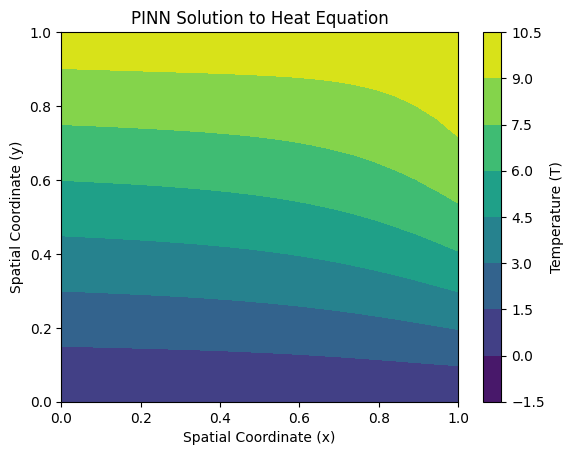

In [ ]:
## 2D contour plot
plt.figure()
contour = plt.contourf(X.numpy(), Y.numpy(), T_pred_plot, cmap='viridis')
plt.colorbar(contour, label='Temperature (T)')
plt.xlabel('Spatial Coordinate (x)')
plt.ylabel('Spatial Coordinate (y)')
plt.title('PINN Solution to Heat Equation')
plt.show()

In [ ]:
## Finding loss from expected value
# Test_loss = (T_test_ - 10*x_test_)
# Ind_loss = numpy.power(Test_loss, 2)
# print(Ind_loss.mean())

In [ ]:
## Adding Gaussian noise to the Temperature data
# x_test = torch.linspace(0.1, 0.9, 11)
# x_test = x_test.reshape(-1, 1)
# T_test = pinn(x_test)
# x_test_ = x_test.detach().numpy()
# T_test_ = T_test.detach().numpy().reshape(x_test.shape)
# mean = 0
# std_dev = 0.1
# gaussian_noise = numpy.random.normal(mean, std_dev, T_test_.shape)
# T_noise_ = T_test_ + gaussian_noise
# T_noise = torch.tensor(T_noise_)

In [ ]:
## Actual training data for Inverse PINN
# x = x_test.requires_grad_(True)
# T_train_actual = T_noise.requires_grad_(True)

In [ ]:
## PDE training data
# x1 = torch.linspace(0, 1, 100).view(-1, 1)
# x1 = x1.view(-1)
# x_train1 = x1.reshape(100, 1).requires_grad_(True)

In [ ]:
## Boundary condition training data
# Temp1val = 0.
# Temp2val = 30.
# Temperature1 = torch.tensor([Temp1val], requires_grad=True)
# Temperature2 = torch.tensor([Temp2val], requires_grad=True)
# x3_1 = torch.tensor([0.]).view(-1, 1)
# x3_2 = torch.tensor([1.]).view(-1, 1)
# x_train_boundary1 = x3_1.requires_grad_(True)
# x_train_boundary2 = x3_2.requires_grad_(True)

In [ ]:
## Initialization of PINN
# torch.manual_seed(68)
# pinn2 = PINN(1,40,1,10)
# parameters = [
#     {'params': pinn2.parameters(), 'lr': 0.0001},
#     {'params': [Temperature2], 'lr': 0.025}
# ]
# optimizer = torch.optim.Adam(parameters)

In [ ]:
## Training Loop
# epochs = 100000
# loss_history = []
# for epoch in range(epochs):

#   optimizer.zero_grad()

#   T_pred_actual = pinn2(x)
#   Actual_loss = (T_pred_actual - T_train_actual).pow(2).mean()

#   T_pred = pinn2(x_train1)
#   pde_loss = heat_equation(T_pred, x_train1).pow(2).mean()

#   T_train_boundary1 = Temperature1
#   T_train_boundary2 = Temperature2
#   T_pred_boundary1 = pinn2(x_train_boundary1)
#   T_pred_boundary2 = pinn2(x_train_boundary2)
#   boundary_condition_loss = (T_pred_boundary1 - T_train_boundary1).pow(2).mean() + (T_pred_boundary2 - T_train_boundary2).pow(2).mean()

#   p1 = 1
#   p2 = 1
#   total_loss = Actual_loss + p1*pde_loss + p2*boundary_condition_loss

#   total_loss.backward(retain_graph=True)
#   optimizer.step()
#   loss_history.append(total_loss.item())
#   if epoch % 5000 == 0:
#       print(f"Epoch {epoch}/{epochs}, Total Loss: {total_loss.item()}, pde Loss: {pde_loss.item()}, Boundary Loss: {boundary_condition_loss.item()}, Temperature2: {Temperature2.item()}")